<a href="https://colab.research.google.com/github/smnststn/Fruits_vegetables/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import os
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout
)

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications import MobileNetV3Large
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

c:\Users\CO2\Desktop\Final project\Fruits_vegetables\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_history(history):
  """
  Funkce na vykreslení dat z objectu history -> vrací ho metoda fit keras modelu
  """
  # plot the Loss curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['loss'], color='orange',linewidth=3.0)
  plt.plot(history.history['val_loss'],color='blue',linewidth=3.0)

  min_val_loss = min(history.history['val_loss'])
  min_val_loss_idx = np.argmin(history.history['val_loss'])
  plt.axhline(min_val_loss, color='red', linestyle='dashed')
  plt.plot(
        min_val_loss_idx,
        min_val_loss,
        'ro',
        label=f'epoch: {min_val_loss_idx}'
  )

  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
  plt.show()

  # plot the Accuracy curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['accuracy'], color='orange', linewidth=3.0)
  plt.plot(history.history['val_accuracy'], color='blue',linewidth=3.0)

  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)
  plt.show()

In [3]:
path = "C:\\Users\\CO2\\Desktop\\Final project\\Fruits_vegetables\\Data"
if os.path.exists(path):
    print(f"Složka '{path}' existuje.")
else:
    print(f"Složka '{path}' neexistuje.")

Složka 'C:\Users\CO2\Desktop\Final project\Fruits_vegetables\Data' existuje.


In [57]:
pass

#import kagglehub

    # Download latest version
    #path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")

    #print("Path to dataset files:", path)

In [4]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
test_dir = os.path.join(path, 'test')

In [5]:
dir_list = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
dir_list.sort()

In [6]:
categories = {i: name for i, name in enumerate(dir_list)}
categories

{0: 'apple',
 1: 'banana',
 2: 'beetroot',
 3: 'bell pepper',
 4: 'cabbage',
 5: 'capsicum',
 6: 'carrot',
 7: 'cauliflower',
 8: 'chilli pepper',
 9: 'corn',
 10: 'cucumber',
 11: 'eggplant',
 12: 'garlic',
 13: 'ginger',
 14: 'grapes',
 15: 'jalepeno',
 16: 'kiwi',
 17: 'lemon',
 18: 'lettuce',
 19: 'mango',
 20: 'onion',
 21: 'orange',
 22: 'paprika',
 23: 'pear',
 24: 'peas',
 25: 'pineapple',
 26: 'pomegranate',
 27: 'potato',
 28: 'raddish',
 29: 'soy beans',
 30: 'spinach',
 31: 'sweetcorn',
 32: 'sweetpotato',
 33: 'tomato',
 34: 'turnip',
 35: 'watermelon'}

In [7]:
def crop_to_square(image):
    """
    Crops an image to a square ratio.
    """
    width, height = image.size

    # Determine the cropping box dimensions
    crop_size = min(width, height)  # Use the smaller dimension for the square
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size

    # Crop the image
    cropped_image = image.crop((left, top, right, bottom))

    return cropped_image

In [8]:
def load_images(path, encoding, image_width = 224, image_height = 224, crop = False, crop_ratio = 1/2, report = False):
  """
  Path = directory of images, Encoding = dictionary of categories
  Function returns  X=images, y=labels
  """

  X = []
  y = []

  # Loop for each category (fruit/vegetable)
  for index, category_name in encoding.items(): # (folder_path)[0:7] --> only first 7 categories / to be removed

    category_path = os.path.join(path, category_name)
    if os.path.exists(category_path):
      image_list = []

      # Loop for each file
      for filename in os.listdir(category_path):

        # Including all formats
        if filename.endswith((".jpg",".png",".jpeg")):
          img_path = os.path.join(category_path, filename)
          img = Image.open(img_path)

          # Get size/ration of image for below reporting
          width, height = img.size
          aspect_ratio = width / height

          if report:
            # Check if actual size is smaller than requested
            if width < image_width or height < image_height:
              print(f"{filename} in category {category_name} has smaller size than requested.")
              print(f"Actual size: {width} x {height} < Requested size:{image_width} x {image_height} \n")

            # Check if the aspect ratio is within the specified range (or default 1/2)
            if (width / height < crop_ratio) or (height / width < crop_ratio):
              print(f"{filename} in category {category_name} has smaller aspect ratio than requested.")
              print(f"Actual aspect ratio: {aspect_ratio:.2f} < Requested aspect ratio:{crop_ratio:.2f} \n")

          # Crops image to square
          if crop:
            img = crop_to_square(img)

          # Convert to RGB
          img.convert('RGB')

          # Resizes to requested width/height (default 224x224)
          img_resized = img.resize((image_width, image_height))
          img_array = np.array(img_resized)

          if img_array.ndim == 2:  # If grayscale, convert to RGB
              img_array = np.stack((img_array,) * 3, axis=-1) # Convert to 3 channels if needed
              # Check if the image has 4 channels (RGBA) and convert if necessary
          elif img_array.shape[2] == 4:  # If RGBA, convert to RGB
              img_array = img_array[:,:,:3] # Removing the alpha channel by selecting only the first 3 (RGB) channels.
          image_list.append(img_array)

      X += image_list
      y += [index] * len(image_list)

  return X, y

In [9]:
X_test, y_test = load_images(test_dir, categories, crop=True)
X_train, y_train = load_images(train_dir, categories, crop=True)
X_val, y_val = load_images(validation_dir, categories, crop=True)

c:\Users\CO2\Desktop\Final project\Fruits_vegetables\.venv\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [10]:
# převést list s numpy arrayi pro každou image na numpy array (tenzor)
X_train = np.stack(X_train)
X_test = np.stack(X_test)
X_val = np.stack(X_val)
# převést list y na numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [11]:
# one hot encoding y -> musí sedět rozměr s výstupem softmax vrstvy
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [12]:
early = EarlyStopping(
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # pokud se nezlepší alespoň o 0.3%
    min_delta=0.003,
    # za posledních 10 epoch
    patience=10,
    # tak to vypni, a načti váhy z epochy, kdy byla nejvyšší přesnost na validačních datech
    restore_best_weights=True,
)

save = ModelCheckpoint(
    # kam uložit model
    filepath="best_model.keras",
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # ulož vždy jen jeden soubor s nejlepší hodnotou metriky
    save_best_only=True,
    # ulož do jednoho souboru architekturu i váhy
    save_weights_only=False,
    # po každé epoše
    save_freq="epoch"
)

In [13]:
# načtení konvoluční featur extraction části MobilnetV3
base_model = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
)

In [14]:
# první MobilnetV3 konvoluční část
x = base_model.output
# převod na vektor s redukcí dat pomocí poolingu
x = GlobalAveragePooling2D()(x)
# stejná klasifikační vrstva jako u vlastní neuronky
# regularizace
x = Dropout(0.2)(x)
x = Dense(36, activation="gelu")(x)

# softmax vrstva podle úlohy
predictions = Dense(36, activation="softmax")(x)


# spojíme do kupy
model = Model(inputs=base_model.input, outputs=predictions)

# nepřetrénovávat MobilnetV3 vrstvy -> učíme pouze klasifikátor
for layer in base_model.layers:
    layer.trainable = False

# kompilace stejná jako u vlastní neuronky
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,032,280 (11.57 MB)

 Trainable params: 35,928 (140.34 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [15]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), batch_size=32, callbacks=[early, save])

Epoch 1/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.2682 - loss: 2.8718 - val_accuracy: 0.7855 - val_loss: 0.9341
Epoch 2/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.7324 - loss: 1.0388 - val_accuracy: 0.8754 - val_loss: 0.4609
Epoch 3/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8047 - loss: 0.6630 - val_accuracy: 0.8928 - val_loss: 0.3415
Epoch 4/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.8475 - loss: 0.5164 - val_accuracy: 0.9072 - val_loss: 0.2848
Epoch 5/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8747 - loss: 0.4172 - val_accuracy: 0.8870 - val_loss: 0.2897
Epoch 6/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.8981 - loss: 0.3391 - val_accuracy: 0.9304 - val_loss: 0.2221
Epoch 7/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9174 - loss: 0.2899 - val_accuracy: 0.9246 - val_loss: 0.2191
Epoch 8/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9096 - loss: 0.2737 - val_accu

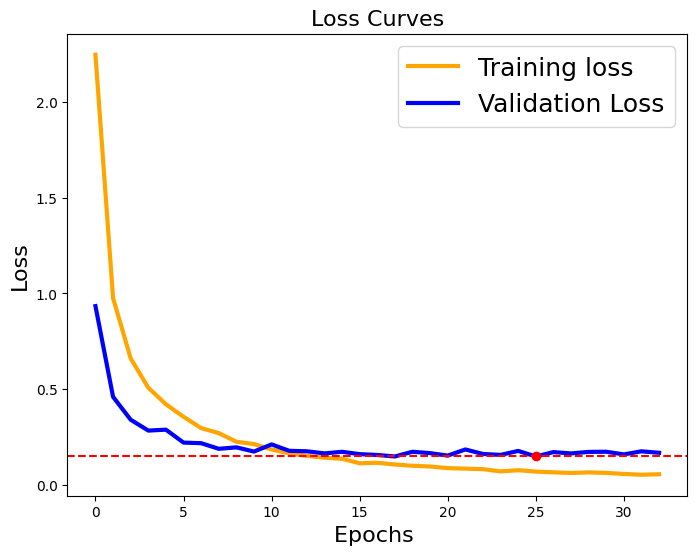

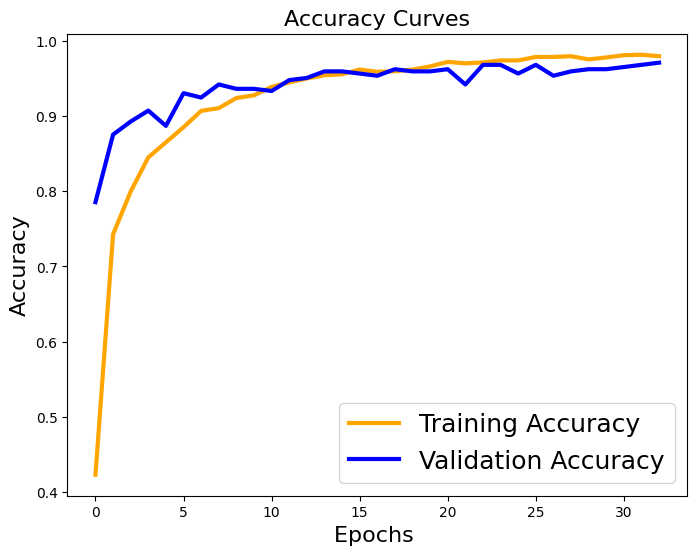

In [16]:
plot_history(history)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [18]:
# Predikce na testovacích datech
y_pred = model.predict(X_val)

# Převést predikce na labely (indexy kategorií)
y_pred_labels = np.argmax(y_pred, axis=1)

# Převést one-hot encoded y_test na labely (indexy kategorií)
y_val_labels = np.argmax(y_val, axis=1)

# Tisk classification reportu
print(classification_report(y_val_labels, y_pred_labels, target_names=np.array(list(categories.values()))))

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step 
               precision    recall  f1-score   support

        apple       0.89      0.89      0.89         9
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       1.00      0.89      0.94         9
      cabbage       1.00      1.00      1.00        10
     capsicum       0.90      1.00      0.95         9
       carrot       1.00      0.88      0.93         8
  cauliflower       1.00      1.00      1.00         9
chilli pepper       1.00      1.00      1.00         9
         corn       0.88      0.70      0.78        10
     cucumber       0.91      1.00      0.95        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         8
     jalepeno       0.90      1.00      0.95         9
         kiwi       1.00

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 817ms/step


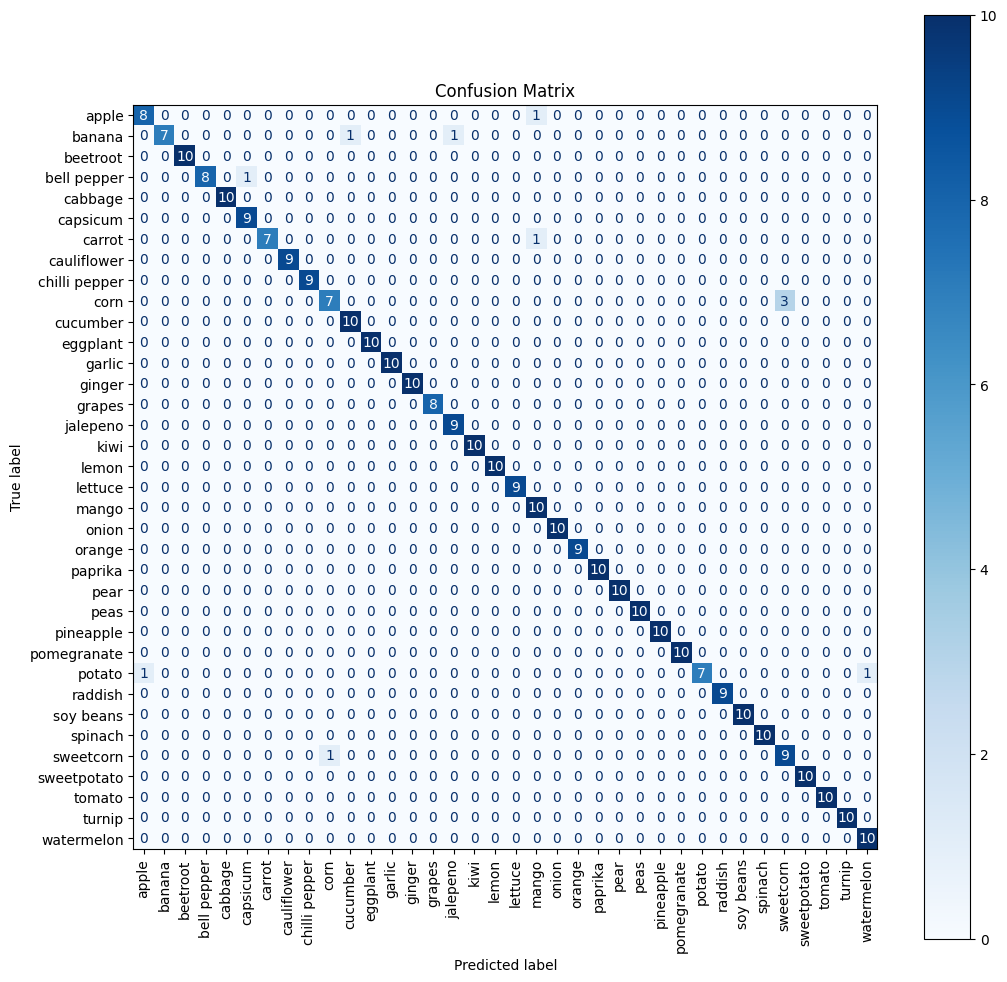

In [19]:
# Redefine class labels from the encoding dictionary
class_labels = list(categories.values())

# Assuming you already loaded your test data into X_test_not_scaled and y_test
# Get the true labels and predicted labels
true_labels = np.argmax(y_val, axis=1)  # Convert one-hot to class indices
pred_labels = model.predict(X_val)
pred_labels = np.argmax(pred_labels, axis=1) # Convert predictions to class indices

# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 12))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.show()

In [20]:
# Create a DataFrame for incorrect predictions
incorrect_predictions = pd.DataFrame({'index': np.where(true_labels != pred_labels)[0],
                                       'true_label': true_labels[np.where(true_labels != pred_labels)[0]],
                                       'predicted_label': pred_labels[np.where(true_labels != pred_labels)[0]]})

# Map label indices to label names using the encoding
incorrect_predictions['true_label_name'] = incorrect_predictions['true_label'].map(categories)
incorrect_predictions['predicted_label_name'] = incorrect_predictions['predicted_label'].map(categories)

# Print the DataFrame
incorrect_predictions

,index,true_label,predicted_label,true_label_name,predicted_label_name
0,5,0,19,apple,mango
1,11,1,15,banana,jalepeno
2,17,1,10,banana,cucumber
3,34,3,5,bell pepper,capsicum
4,60,6,19,carrot,mango
5,85,9,31,corn,sweetcorn
6,90,9,31,corn,sweetcorn
7,91,9,31,corn,sweetcorn
8,259,27,0,potato,apple
9,264,27,35,potato,watermelon


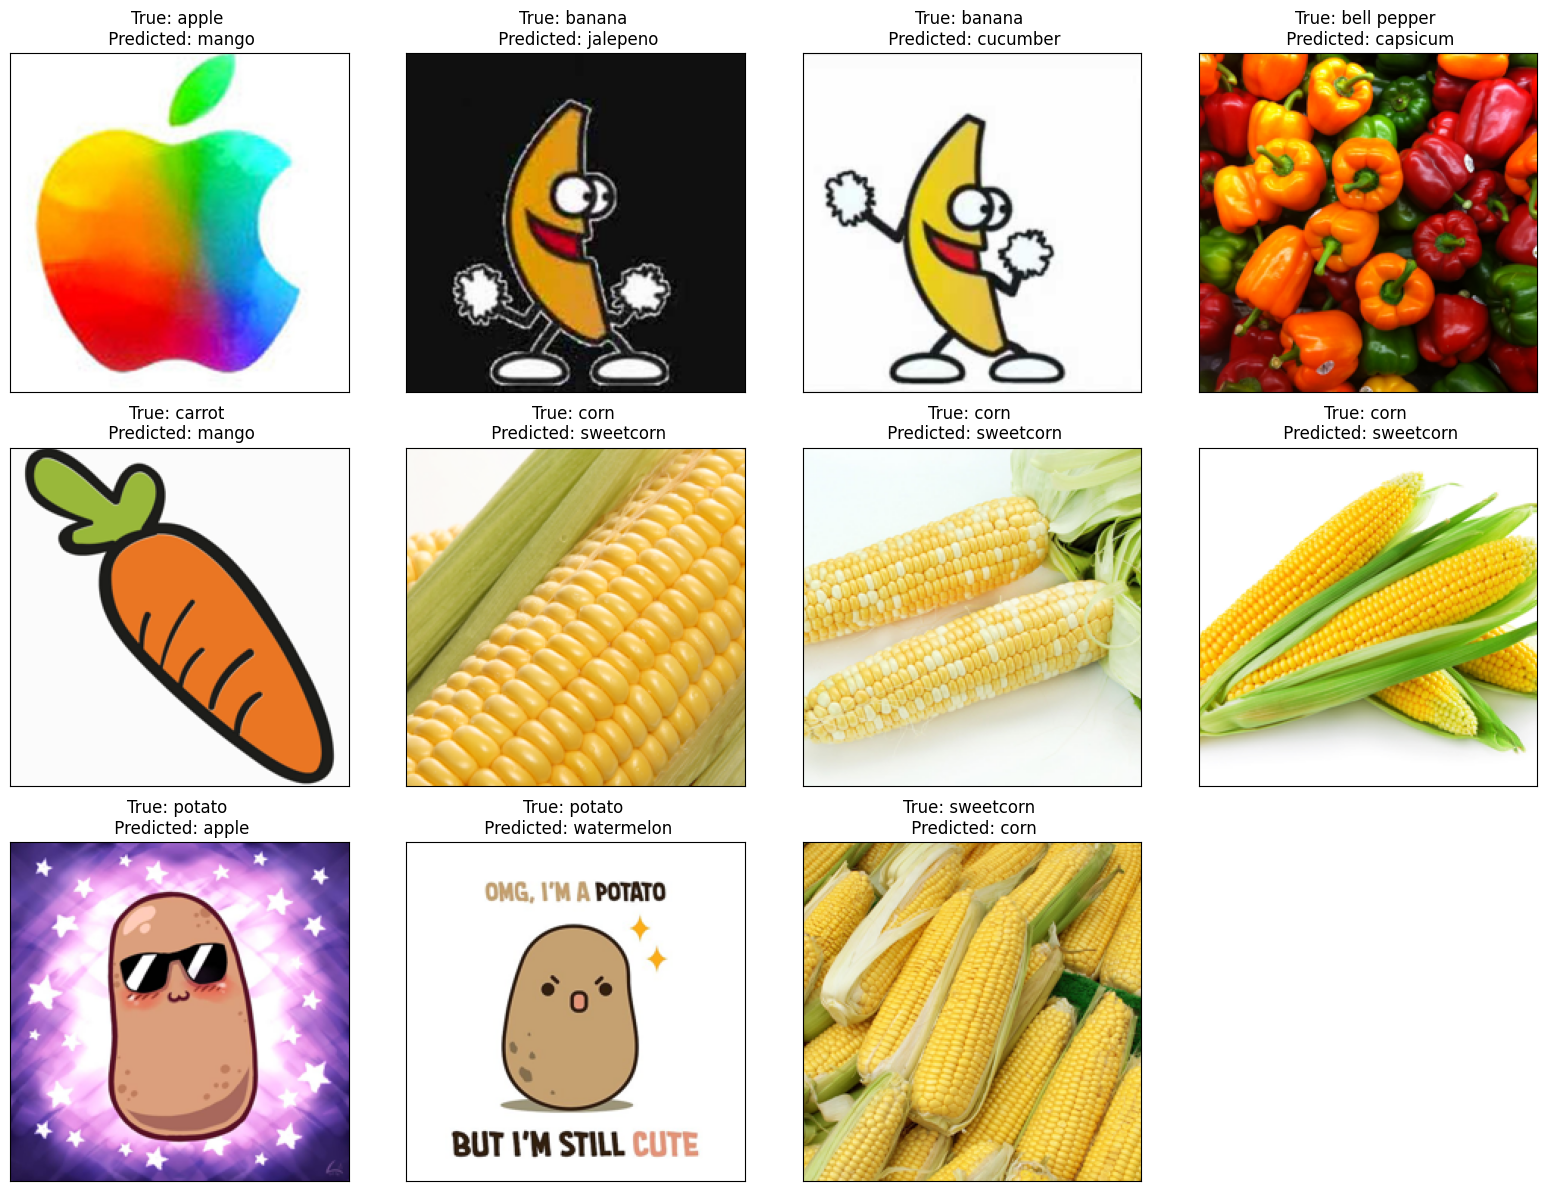

In [21]:
# Calculate grid dimensions
num_images = len(incorrect_predictions)
grid_cols = 4  # Number of columns in the grid
grid_rows = int(np.ceil(num_images / grid_cols))

# Create the grid of subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))  # Adjust figsize as needed

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through images and plot on grid
for i, index in enumerate(incorrect_predictions['index']):
    # Display the image on the subplot
    axes[i].imshow(X_val[index])

    # Set the title of the subplot
    title = f"True: {incorrect_predictions.loc[incorrect_predictions['index'] == index, 'true_label_name'].iloc[0]} \n Predicted: {incorrect_predictions.loc[incorrect_predictions['index'] == index, 'predicted_label_name'].iloc[0]}"
    axes[i].set_title(title)

    # Remove ticks and labels from the subplot
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Hide any unused subplots
for j in range(num_images, grid_cols * grid_rows):
    axes[j].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()